# Part 2 LES Dataset

Build a SOM for our LES dataset. Use the code that you think works better. What's the accuracy on detecting LES observations?

## 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import pickle
%matplotlib inline

## 2. Reading Michigan LES dataset

In [2]:
combined_df = pd.read_csv('data/LES/MI_14840_2013Fall_2014Spring.csv') 

## 3. Exploratory Data Analysis

In [3]:
combined_df.describe()

,Date_CST,Date_UTC_x,Mean,Centroid_lon,Centroid_lat,Std_lon,Std_lat,Skewness_lon,Skewness_lat,Kurtosis_lon,Kurtosis_lat,Sample Number,Date_UTC_y
count,4.369000e+03,4.330000e+03,4330.000000,4330.000000,4330.000000,4330.000000,4330.000000,4330.000000,4330.000000,4330.000000,4330.000000,4330.000000,4.363000e+03
mean,2.013561e+07,2.013562e+07,0.148562,-86.727685,43.903336,0.638892,1.226344,0.633697,0.049573,2.997534,1.755657,3.584988,2.013562e+07
std,4.550838e+03,4.550669e+03,0.210334,0.074446,0.154493,0.028039,0.040397,0.103137,0.176354,0.268166,0.155327,0.573380,4.550747e+03
min,2.013100e+07,2.013100e+07,0.000812,-87.149116,42.731292,0.389177,0.622282,-0.052495,-1.043359,1.935527,1.410064,2.000000,2.013100e+07
25%,2.013112e+07,2.013112e+07,0.002022,-86.753975,43.856222,0.627505,1.213380,0.598286,-0.002104,2.876930,1.695515,3.000000,2.013112e+07
50%,2.013123e+07,2.013123e+07,0.002595,-86.733673,43.906049,0.640335,1.230377,0.637683,0.045020,2.973932,1.724313,4.000000,2.013123e+07
75%,2.014021e+07,2.014021e+07,0.290761,-86.710420,43.949023,0.651723,1.244278,0.678638,0.102448,3.089841,1.764495,4.000000,2.014021e+07
max,2.014033e+07,2.014033e+07,0.956265,-86.340049,44.699625,0.818549,1.467391,1.382664,2.265091,6.377330,6.867313,4.000000,2.014033e+07


### a. Dropping redundant Date Time columns

We will keep only one column relevant to date and time and drop others

In [4]:
remove_col = ['Date_CST', 'Time_CST',
              'Date_UTC_x', 'Time_UTC_x','Date_UTC_y', 'Time_UTC_y']
combined_df = combined_df.drop(remove_col, axis = 1) 
combined_df = combined_df.reset_index(drop=True)

Renaming column names by replacing spaces by underscores and removing brackets 

In [5]:
combined_df.columns = combined_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
combined_df.columns

/var/folders/pw/kjv2697x6q18wbdd7j7x8w_00000gn/T/ipykernel_6698/1553413785.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  combined_df.columns = combined_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/pw/kjv2697x6q18wbdd7j7x8w_00000gn/T/ipykernel_6698/1553413785.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  combined_df.columns = combined_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')


Index(['date', 'time', 'temp_f', 'rh_%', 'dewpt_f', 'wind_spd_mph',
       'wind_direction_deg', 'peak_wind_gustmph', 'low_cloud_ht_ft',
       'med_cloud_ht_ft', 'high_cloud_ht_ft', 'visibility_mi', 'atm_press_hpa',
       'sea_lev_press_hpa', 'altimeter_hpa', 'precip_in', 'wind_chill_f',
       'heat_index_f', 'mean', 'centroid_lon', 'centroid_lat', 'std_lon',
       'std_lat', 'skewness_lon', 'skewness_lat', 'kurtosis_lon',
       'kurtosis_lat', 'sample_number', 'selected', 'lake_visible',
       'les_exist'],
      dtype='object')

### b. Dropping column containing noisy data

Now let's take a look at unique values in the dataset. We will print all the unique values in each column

In [6]:
for var in combined_df.columns:
    print(combined_df[var].unique())

['2013-10-01' '2013-10-02' '2013-10-03' '2013-10-04' '2013-10-05'
 '2013-10-06' '2013-10-07' '2013-10-08' '2013-10-09' '2013-10-10'
 '2013-10-11' '2013-10-12' '2013-10-13' '2013-10-14' '2013-10-15'
 '2013-10-16' '2013-10-17' '2013-10-18' '2013-10-19' '2013-10-20'
 '2013-10-21' '2013-10-22' '2013-10-23' '2013-10-24' '2013-10-25'
 '2013-10-26' '2013-10-27' '2013-10-28' '2013-10-29' '2013-10-30'
 '2013-10-31' '2013-11-01' '2013-11-02' '2013-11-03' '2013-11-04'
 '2013-11-05' '2013-11-06' '2013-11-07' '2013-11-08' '2013-11-09'
 '2013-11-10' '2013-11-11' '2013-11-12' '2013-11-13' '2013-11-14'
 '2013-11-15' '2013-11-16' '2013-11-17' '2013-11-18' '2013-11-19'
 '2013-11-20' '2013-11-21' '2013-11-22' nan '2013-11-23' '2013-11-24'
 '2013-11-25' '2013-11-26' '2013-11-27' '2013-11-28' '2013-11-29'
 '2013-11-30' '2013-12-01' '2013-12-02' '2013-12-03' '2013-12-04'
 '2013-12-05' '2013-12-06' '2013-12-07' '2013-12-08' '2013-12-09'
 '2013-12-10' '2013-12-11' '2013-12-12' '2013-12-13' '2013-12-14'
 '2013

We observe that there are some irrelevant values like 'M','m' and 'NC'. We don't need these. <br>
So we will replace these noisy values by NaN and further check how many total nulls are present in each column

In [7]:
combined_df.replace('m', np.nan, inplace=True)
combined_df.replace('M', np.nan, inplace=True)
combined_df.replace('NC', np.nan, inplace=True)
combined_df.isnull().sum()

date                     1
time                     1
temp_f                   4
rh_%                     4
dewpt_f                  4
wind_spd_mph            21
wind_direction_deg      29
peak_wind_gustmph     3241
low_cloud_ht_ft        499
med_cloud_ht_ft       2705
high_cloud_ht_ft      3799
visibility_mi            4
atm_press_hpa            8
sea_lev_press_hpa      439
altimeter_hpa            8
precip_in              301
wind_chill_f          1100
heat_index_f          4369
mean                    39
centroid_lon            39
centroid_lat            39
std_lon                 39
std_lat                 39
skewness_lon            39
skewness_lat            39
kurtosis_lon            39
kurtosis_lat            39
sample_number           39
selected                39
lake_visible             6
les_exist                6
dtype: int64

We would now elimate the columns having highest number of nulls.
The top 5 columns having noisy data are - `peak_wind_gustmph`, `high_cloud_ht_ft`, `heat_index_f`, `med_cloud_ht_ft`, `wind_chill_f`, `low_cloud_ht_ft` and `sea_lev_press_hpa`. <br>
So we will drop these columns.

In [8]:
combined_df = combined_df.drop(['peak_wind_gustmph', 'high_cloud_ht_ft', 'heat_index_f', 
                                'med_cloud_ht_ft','wind_chill_f', 'low_cloud_ht_ft',
                               'sea_lev_press_hpa'], axis = 1)
combined_df.shape

(4369, 24)

### c. Dropping null rows from the dataset

Let's now drop all the null rows in the remaining dataset

In [9]:
# Dropping nulls
combined_df = combined_df.dropna()
combined_df = combined_df.reset_index(drop = True)
combined_df.isnull().sum()

date                  0
time                  0
temp_f                0
rh_%                  0
dewpt_f               0
wind_spd_mph          0
wind_direction_deg    0
visibility_mi         0
atm_press_hpa         0
altimeter_hpa         0
precip_in             0
mean                  0
centroid_lon          0
centroid_lat          0
std_lon               0
std_lat               0
skewness_lon          0
skewness_lat          0
kurtosis_lon          0
kurtosis_lat          0
sample_number         0
selected              0
lake_visible          0
les_exist             0
dtype: int64

Now we don't have nulls in the data. Let's again look at the data to see if we are having any other problems

In [10]:
for var in combined_df.columns:
    print(combined_df[var].value_counts())

2013-10-01    24
2014-01-07    24
2014-01-01    24
2013-12-28    24
2013-12-03    24
              ..
2013-11-22    17
2013-12-31    16
2014-01-08    15
2013-11-17    14
2014-03-07    11
Name: date, Length: 182, dtype: int64
07:55    170
17:55    169
20:55    169
19:55    169
18:55    167
        ... 
04:50      1
14:53      1
15:53      1
16:51      1
11:53      1
Name: time, Length: 98, dtype: int64
21    124
19    113
20    110
16    106
23    106
     ... 
-2      4
-4      3
-7      2
-6      1
-5      1
Name: temp_f, Length: 82, dtype: int64
67    165
69    156
64    144
72    138
73    126
     ... 
29      1
31      1
33      1
30      1
23      1
Name: rh_%, Length: 66, dtype: int64
10     127
32     126
31     124
14     117
29     112
      ... 
-12      3
-11      3
54       2
59       2
67       1
Name: dewpt_f, Length: 81, dtype: int64
8     328
9     323
10    320
11    315
0     297
13    281
7     256
6     252
5     244
14    233
15    227
3     183
16    175
17    12

Here we observe that `selected` column is having just one single value, so we can drop it as it doesn't add any information to our dataset

In [11]:
combined_df = combined_df.drop('selected', axis = 1)

### d. Converting categorial data to numeric

Next we will convert the categorical labels `lake_visible` and `les_exist` to numeric

In [12]:
combined_df['lake_visible'] = combined_df['lake_visible'].replace(to_replace=r'Y', value=r'1', regex=True)
combined_df['lake_visible'] = combined_df['lake_visible'].replace(to_replace=r'N', value=r'0', regex=True)
combined_df['les_exist'] = combined_df['les_exist'].replace(to_replace=r'Y', value=r'1', regex=True)
combined_df['les_exist'] = combined_df['les_exist'].replace(to_replace=r'N', value=r'0', regex=True)

In [13]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                4005 non-null   object 
 1   time                4005 non-null   object 
 2   temp_f              4005 non-null   object 
 3   rh_%                4005 non-null   object 
 4   dewpt_f             4005 non-null   object 
 5   wind_spd_mph        4005 non-null   object 
 6   wind_direction_deg  4005 non-null   object 
 7   visibility_mi       4005 non-null   object 
 8   atm_press_hpa       4005 non-null   object 
 9   altimeter_hpa       4005 non-null   object 
 10  precip_in           4005 non-null   object 
 11  mean                4005 non-null   float64
 12  centroid_lon        4005 non-null   float64
 13  centroid_lat        4005 non-null   float64
 14  std_lon             4005 non-null   float64
 15  std_lat             4005 non-null   float64
 16  skewne

Now we will convert all the data types to numeric

In [14]:
combined_df.iloc[:,2:] = combined_df.iloc[:,2:].apply(lambda x : pd.to_numeric(x , errors = 'coerce'))
combined_df.dtypes

date                   object
time                   object
temp_f                  int64
rh_%                    int64
dewpt_f                 int64
wind_spd_mph            int64
wind_direction_deg      int64
visibility_mi           int64
atm_press_hpa         float64
altimeter_hpa         float64
precip_in             float64
mean                  float64
centroid_lon          float64
centroid_lat          float64
std_lon               float64
std_lat               float64
skewness_lon          float64
skewness_lat          float64
kurtosis_lon          float64
kurtosis_lat          float64
sample_number         float64
lake_visible            int64
les_exist               int64
dtype: object

## 4. Adding Target Column

Adding the target column (LES_SNOWFALL) to the dataset.
Condition = if Temp < 32 and Precip > 0 then Y (1) else N (0)

In [15]:
combined_df['les_snowfall'] = np.where((combined_df['temp_f'] <= 32) & (combined_df['precip_in'] > 0), 1, 0)

We will also drop Temp and Precip columns to prevent the bias in the model

In [16]:
combined_df = combined_df.drop(['temp_f','precip_in'], axis = 1) 
combined_df.head()

,date,time,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,atm_press_hpa,altimeter_hpa,mean,...,std_lon,std_lat,skewness_lon,skewness_lat,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist,les_snowfall
0,2013-10-01,00:55,77,51,8,160,10,989.9,1012.9,0.001979,...,0.665668,1.226432,0.582646,0.007014,2.816020,1.711882,3.0,0,0,0
1,2013-10-01,01:55,80,52,6,160,10,990.2,1013.2,0.002175,...,0.670232,1.239065,0.660357,0.030175,2.863913,1.689899,4.0,0,0,0
2,2013-10-01,02:55,86,53,5,160,10,990.2,1013.2,0.007346,...,0.649593,1.235327,0.630409,0.023720,2.893504,1.712862,4.0,0,0,0
3,2013-10-01,03:55,86,59,9,190,10,990.2,1013.2,0.001971,...,0.656606,1.235076,0.614300,0.024125,2.869601,1.716328,3.0,0,0,0
4,2013-10-01,04:55,86,60,9,190,10,990.2,1013.2,0.008081,...,0.625056,1.225389,0.684025,0.192531,3.150438,1.765415,4.0,0,0,0


In [17]:
from collections import Counter
cnt = Counter(combined_df['les_snowfall'])
cnt

Counter({0: 3751, 1: 254})

### Converting the target variable column to int64 dtype

In [18]:
combined_df = combined_df.astype({'les_snowfall': 'int64'})

The data is quite imbalanced.

## 5. Balancing the dataset

If there is a snowfall on any one hour of the day, we can assume that there waw snow falling for that "day".<br>
So we will extract all the dates in `dates_snowfall` where these was snowfall for any hour of the day, and then assign the `target_snow` column as 1 for all the rows for that day.

In [19]:
dates_snowfall = set()
for index,row in combined_df.iterrows():
    if row['les_snowfall']==1:
        dates_snowfall.add(row['date'])


In [20]:
combined_df['target_snow'] = np.where(combined_df['date'].isin(dates_snowfall),1,0)

Converting the target column to int64

In [21]:
combined_df = combined_df.astype({'target_snow':'int64'})
combined_df.dtypes

date                   object
time                   object
rh_%                    int64
dewpt_f                 int64
wind_spd_mph            int64
wind_direction_deg      int64
visibility_mi           int64
atm_press_hpa         float64
altimeter_hpa         float64
mean                  float64
centroid_lon          float64
centroid_lat          float64
std_lon               float64
std_lat               float64
skewness_lon          float64
skewness_lat          float64
kurtosis_lon          float64
kurtosis_lat          float64
sample_number         float64
lake_visible            int64
les_exist               int64
les_snowfall            int64
target_snow             int64
dtype: object

Checking for one of the dates

In [22]:
combined_df[combined_df['date']=='2014-03-24'][['date','les_snowfall','target_snow']]

,date,les_snowfall,target_snow
3828,2014-03-24,0,1
3829,2014-03-24,0,1
3830,2014-03-24,0,1
3831,2014-03-24,0,1
3832,2014-03-24,1,1
3833,2014-03-24,0,1
3834,2014-03-24,0,1
3835,2014-03-24,0,1
3836,2014-03-24,0,1
3837,2014-03-24,0,1


Now let's check the distribution of the new target variable

In [23]:
cnt = Counter(combined_df['target_snow'])
cnt

Counter({0: 2701, 1: 1304})

## 6. Feature Engineering

### a. Correlation

<AxesSubplot:>

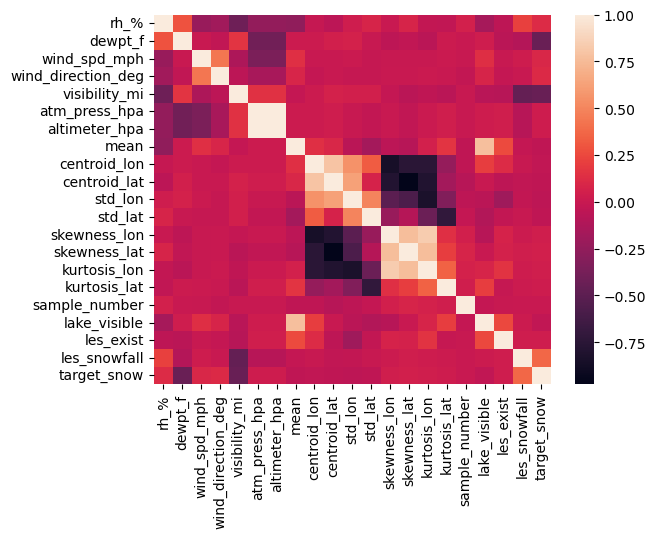

In [24]:
corr = combined_df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values )

### b. Dropping highly correlated features
Removing `centroid_lon`, `centroid_lat` and `atm_press_hpa` due it's high correlation with other columns

In [25]:
combined_df = combined_df.drop(['centroid_lon', 'centroid_lat','atm_press_hpa'], axis = 1)
combined_df.shape

(4005, 20)

## 6. Shifting the dataframe to predict 3 days prior

As we want to predict the snowfall some days in advance, we will shift the target column.

In [26]:
def shift_col_hrs(data, hours):
    data3 = data.copy()
    data3['target_snow'] = data.target_snow.shift(-hours)
    data3 = data3.dropna()
    data3 = data3.reset_index(drop=True)
    return data3

Shifting the target column by 3 days i.e 72 hours

In [27]:
s_df = shift_col_hrs(combined_df,72)
print(s_df.shape)
s_df.tail()

(3933, 20)


,date,time,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,altimeter_hpa,mean,std_lon,std_lat,skewness_lon,skewness_lat,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist,les_snowfall,target_snow
3928,2014-03-28,11:55,75,28,18,330,10,1013.9,0.167383,0.733378,1.278658,0.656385,-0.080240,2.727861,1.673418,4.0,1,0,0,0.0
3929,2014-03-28,12:55,72,28,15,340,10,1015.2,0.179933,0.723208,1.277780,0.660659,-0.032906,2.770232,1.656046,3.0,1,0,0,0.0
3930,2014-03-28,13:55,69,28,14,350,10,1015.6,0.192494,0.707747,1.272414,0.672086,0.024177,2.845752,1.652426,4.0,1,0,0,0.0
3931,2014-03-28,15:55,69,27,11,290,10,1019.3,0.194327,0.689577,1.269394,0.686624,0.020473,2.900023,1.683128,3.0,1,0,0,0.0
3932,2014-03-28,16:55,72,27,15,320,10,1020.0,0.173158,0.671477,1.261126,0.687091,0.049914,2.970425,1.695698,4.0,1,0,0,0.0


## 7. Declare feature vector and target variable

In [28]:
s_df.columns

Index(['date', 'time', 'rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist', 'les_snowfall',
       'target_snow'],
      dtype='object')

In [29]:
X_dev = ['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist']

In [30]:
X = pd.DataFrame(s_df , columns = X_dev)
print("Independant variables : ")
print(X.columns)
y = s_df['target_snow']
print("Dependant variable : target_snow")

Independant variables : 
Index(['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist'],
      dtype='object')
Dependant variable : target_snow


In [31]:
X.shape, y.shape

((3933, 16), (3933,))

### Scaling the feature set

In [32]:
from sklearn import preprocessing
X = preprocessing.scale(X)

## 8. Splitting into train and test dataset

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [34]:
X_train.shape, y_train.shape

((3146, 16), (3146,))

## 9. Predicting using SOM

**SuSi** (https://github.com/felixriese/susi)

The SuSi framework is based on an unsupervised SOM and can be applied for unsupervised clustering and for the visualization of data.

Additionally, the SuSi framework includes supervised regression and classification SOMs to estimate continuous or discrete variable based on input data.

In [35]:
!pip install susi

In [36]:
import susi
from susi.SOMPlots import plot_umatrix, plot_estimation_map, plot_nbh_dist_weight_matrix

## a. On Balanced Dataset
Here our feature set is balanced in accordance to our target variable *target_snow*

In [37]:
som1 = susi.SOMClassifier(
    n_rows=40,
    n_columns=40,
    n_iter_unsupervised=1000,
    n_iter_supervised=1000,
    random_state=0)

# som1.fit(X_train, y_train)

# with open('SOM_Balanced_LES_Michigan.pkl', 'wb') as files:
#     pickle.dump(som1, files)


Loading the model from pickle file:

In [38]:
with open('pickle/SOM_Balanced_LES_Michigan.pkl' , 'rb') as f:
    som1 = pickle.load(f)

In [39]:
y_pred = som1.predict(X_test)
print("Accuracy: {0:.1f} %".format(som1.score(X_test, y_test)*100))

Accuracy: 49.9 %


### Plotting the U-Matrix

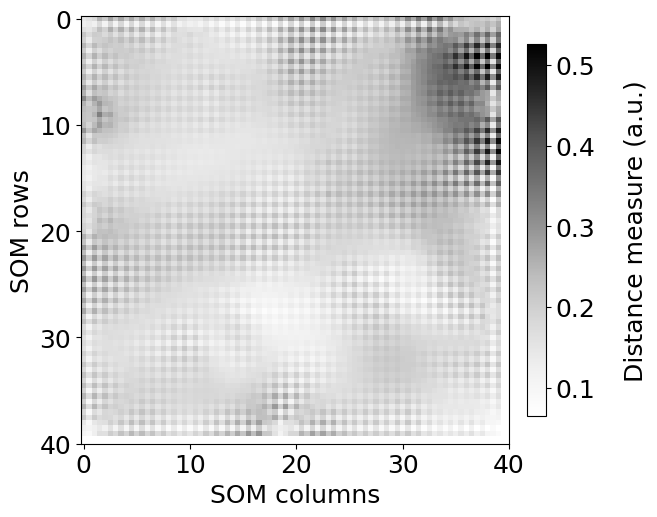

In [40]:
u_matrix = som1.get_u_matrix()
plot_umatrix(u_matrix, 40, 40)
plt.show()

### Estimation Map

Darker regions represent the neuron classified with class 0 and yeloow ones represent class 1

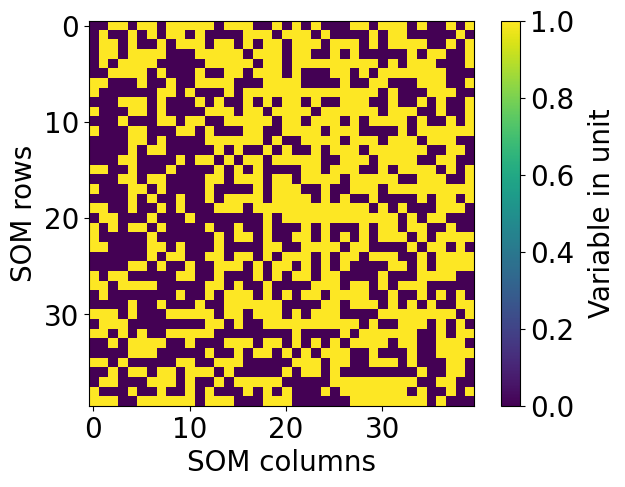

In [41]:
estimation_map = som1.get_estimation_map().squeeze()
plot_estimation_map(estimation_map)
plt.show()

### Plotting the neighborhood distance

It will be a Gaussian

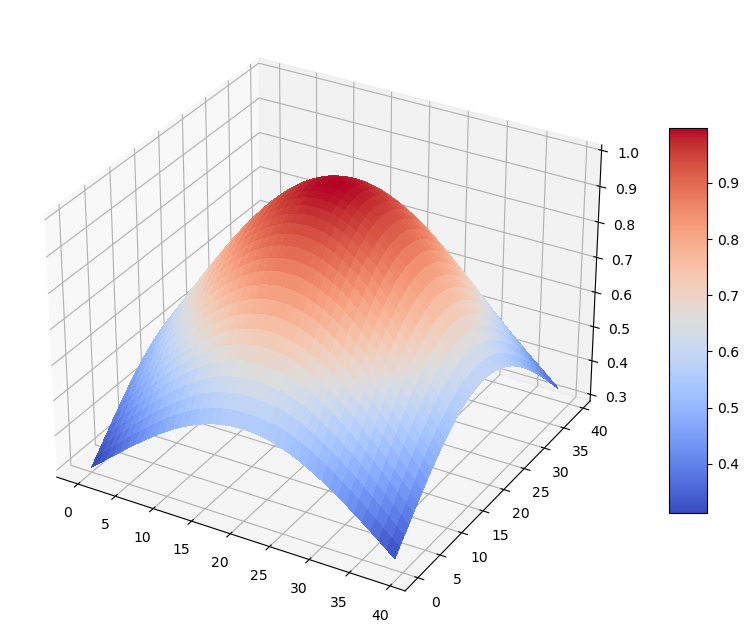

In [42]:
plot_nbh_dist_weight_matrix(som1)
plt.show()

## b. On original imbalanced dataset
Here our feature set `combined_df` is not balanced wrt the target variable *les_snowfall*

In [43]:
X = pd.DataFrame(combined_df , columns = X_dev)
print("Independant variables : ")
print(X.columns)
y = combined_df['les_snowfall']
print("Dependant variable : les_snowfall")

Independant variables : 
Index(['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist'],
      dtype='object')
Dependant variable : les_snowfall


In [44]:
X.dtypes

rh_%                    int64
dewpt_f                 int64
wind_spd_mph            int64
wind_direction_deg      int64
visibility_mi           int64
altimeter_hpa         float64
mean                  float64
std_lon               float64
std_lat               float64
skewness_lon          float64
skewness_lat          float64
kurtosis_lon          float64
kurtosis_lat          float64
sample_number         float64
lake_visible            int64
les_exist               int64
dtype: object

In [45]:
y_train

2638    1.0
3555    0.0
1922    0.0
3599    0.0
578     0.0
       ... 
1130    1.0
1294    0.0
860     0.0
3507    0.0
3174    1.0
Name: target_snow, Length: 3146, dtype: float64

In [46]:
X.shape, y.shape

((4005, 16), (4005,))

In [47]:
## rescaling
from sklearn import preprocessing
X = preprocessing.scale(X)

In [48]:
## Splitting into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, y_train.shape

((3204, 16), (3204,))

### SOM prediction

In [49]:
som2 = susi.SOMClassifier(
    n_rows=40,
    n_columns=40,
    n_iter_unsupervised=1000,
    n_iter_supervised=1000,
    random_state=0)

# som2.fit(X_train, y_train)

# with open('SOM_Imbalanced_LES_Michigan.pkl', 'wb') as files:
#     pickle.dump(som2, files)

#Loading from pickle file
with open('pickle/SOM_Imbalanced_LES_Michigan.pkl' , 'rb') as f:
    som2 = pickle.load(f)


y_pred = som2.predict(X_test)
print("Accuracy: {0:.1f} %".format(som2.score(X_test, y_test)*100))

Accuracy: 66.9 %


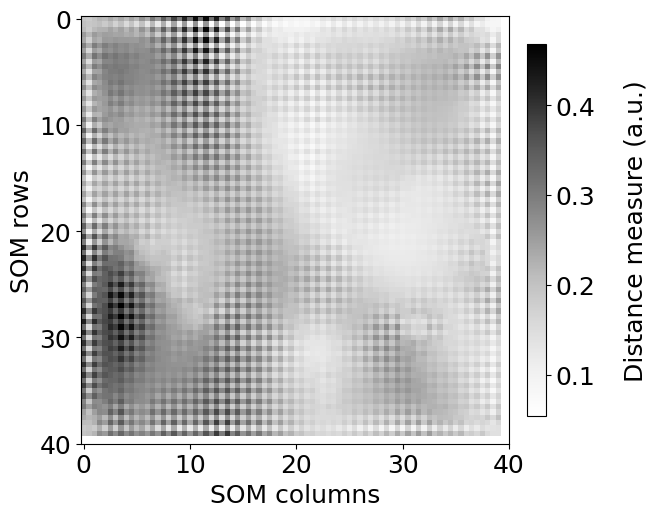

In [50]:
## U-matrix

u_matrix = som2.get_u_matrix()
plot_umatrix(u_matrix, 40, 40)
plt.show()

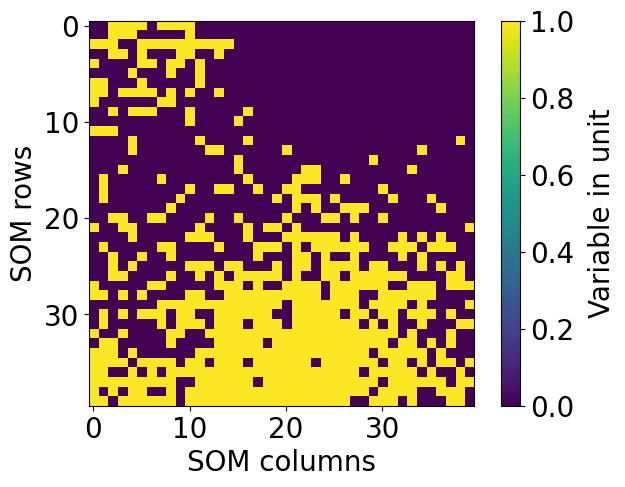

In [51]:
## Estimation Map

estimation_map = som2.get_estimation_map().squeeze()
plot_estimation_map(estimation_map)
plt.show()

# Approach 2

In order to balance the dataset we said that the whole day will have snowfall if it snows just for an hour in that day.
Let's try to group by `date` by taking mean of other features and try to fit our model to this dataset.

In [52]:
combined_df.shape

(4005, 20)

## Dropping the 'time' column

In [53]:
combined_df= combined_df.drop(['time'], axis = 1)

## Grouping by date
Excluding the target variable while grouping

In [54]:
grouped_df = combined_df.iloc[:,:-1].groupby('date').mean()
grouped_df.shape

(182, 17)

In [55]:
grouped_df.head()

,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,altimeter_hpa,mean,std_lon,std_lat,skewness_lon,skewness_lat,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist,les_snowfall
date,,,,,,,,,,,,,,,,,
2013-10-01,80.333333,60.208333,14.166667,198.750000,9.041667,1013.075000,0.148176,0.622259,1.204662,0.699497,0.153411,3.197222,1.823221,3.583333,0.458333,0.0,0.0
2013-10-02,59.095238,47.523810,1.809524,76.666667,10.000000,1017.942857,0.151192,0.668140,1.218159,0.470668,-0.235718,2.643327,1.941562,3.571429,0.523810,0.0,0.0
2013-10-03,75.150000,56.400000,7.550000,140.500000,9.200000,1014.500000,0.143127,0.617063,1.190154,0.707618,0.258960,3.292876,1.963915,3.550000,0.400000,0.0,0.0
2013-10-04,84.260870,63.913043,7.347826,180.000000,9.304348,1015.104348,0.127956,0.648451,1.217933,0.637917,0.012106,2.960220,1.768402,3.608696,0.434783,0.0,0.0
2013-10-05,85.954545,64.590909,9.227273,123.181818,8.136364,1012.900000,0.214705,0.668726,1.279343,0.610067,0.090971,2.836646,1.708494,3.545455,0.500000,0.0,0.0


## Adding the target variable

In [56]:
grouped_df['target_snow'] = np.where(grouped_df.index.isin(dates_snowfall),1,0)

In [57]:
cnt = Counter(grouped_df['target_snow'])
cnt

Counter({0: 120, 1: 62})

Not that imbalanced.

## Shifting the dataframe

As we want to predict the snowfall some days in advance, we will shift the target column.

In [58]:
def shift_col(data, days):
    data3 = data.copy()
    data3['target_snow'] = data.target_snow.shift(-days)
    data3 = data3.dropna()
    data3 = data3.reset_index(drop=True)
    return data3

Shifting the target column by 3 days 

In [59]:
shifted_df = shift_col(grouped_df,3)
print(shifted_df.shape)
shifted_df.tail()

(179, 18)


,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,altimeter_hpa,mean,std_lon,std_lat,skewness_lon,skewness_lat,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist,les_snowfall,target_snow
174,64.173913,12.391304,8.521739,168.260870,9.391304,1023.239130,0.252299,0.644340,1.232516,0.644349,0.034896,2.974837,1.742175,3.608696,0.434783,0.0,0.043478,0.0
175,58.857143,11.857143,13.714286,309.047619,8.619048,1017.033333,0.235822,0.637645,1.212747,0.676408,0.085969,3.094394,1.796018,3.523810,0.476190,0.0,0.047619,0.0
176,59.166667,11.916667,8.333333,150.416667,9.916667,1022.995833,0.223560,0.619279,1.199097,0.662318,0.076742,3.207596,1.786320,3.583333,0.458333,0.0,0.000000,0.0
177,69.272727,28.681818,14.909091,166.818182,7.136364,1008.177273,0.115061,0.679036,1.294002,0.717013,0.175323,2.962430,1.696067,3.590909,0.454545,0.0,0.000000,0.0
178,77.090909,30.000000,13.454545,219.090909,8.409091,1011.963636,0.082998,0.667838,1.247813,0.644898,0.018409,2.900324,1.698789,3.590909,0.454545,0.0,0.000000,0.0


In [60]:
print(Counter(shifted_df['target_snow']))

Counter({0.0: 117, 1.0: 62})


## Declaring the feature set and target variable

In [61]:
shifted_df.columns

Index(['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist', 'les_snowfall',
       'target_snow'],
      dtype='object')

In [62]:
X_dev = ['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist']

In [63]:
X = pd.DataFrame(shifted_df , columns = X_dev)
print("Independant variables : ")
print(X.columns)
y = shifted_df['target_snow']
print("Dependant variable : target_snow")

Independant variables : 
Index(['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'altimeter_hpa', 'mean', 'std_lon', 'std_lat',
       'skewness_lon', 'skewness_lat', 'kurtosis_lon', 'kurtosis_lat',
       'sample_number', 'lake_visible', 'les_exist'],
      dtype='object')
Dependant variable : target_snow


In [64]:
from sklearn import preprocessing
X = preprocessing.scale(X)

## Splitting into train and test dataset

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [66]:
cnt = Counter(y_train)
cnt

Counter({0.0: 93, 1.0: 50})

In [67]:
cnt = Counter(y_test)
cnt

Counter({1.0: 12, 0.0: 24})

## SOM prediction

In [68]:
som3 = susi.SOMClassifier(
    n_rows=40,
    n_columns=40,
    n_iter_unsupervised=1000,
    n_iter_supervised=1000,
    random_state=0)

# som3.fit(X_train, y_train)

# with open('SOM_Balanced_Grouped_LES_Michigan.pkl', 'wb') as files:
#     pickle.dump(som3, files)

#Loading from pickle file
with open('pickle/SOM_Balanced_Grouped_LES_Michigan.pkl' , 'rb') as f:
    som3 = pickle.load(f)

y_pred = som3.predict(X_test)
print("Accuracy: {0:.1f} %".format(som3.score(X_test, y_test)*100))

Accuracy: 52.8 %


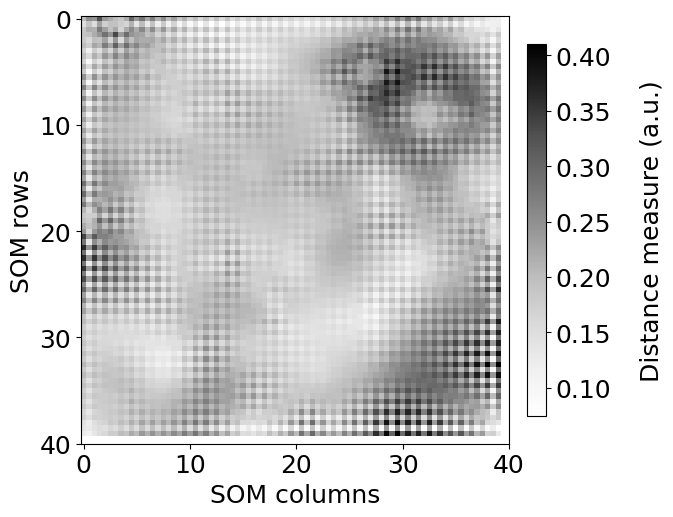

In [69]:
## U-matrix

u_matrix = som3.get_u_matrix()
plot_umatrix(u_matrix, 40, 40)
plt.show()

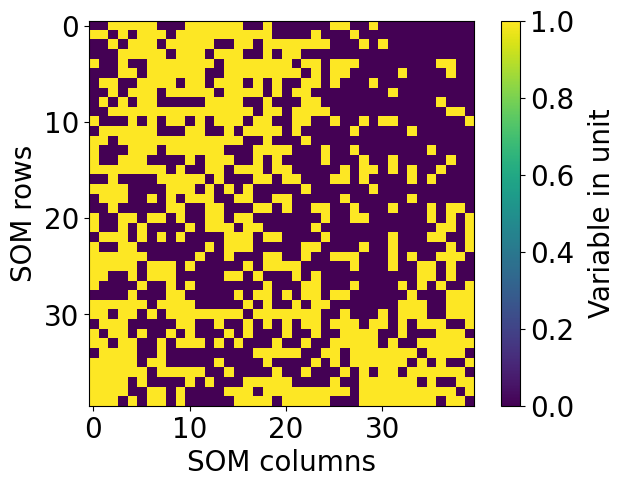

In [70]:
## Estimation Map

estimation_map = som3.get_estimation_map().squeeze()
plot_estimation_map(estimation_map)
plt.show()

# Conclusion:

## Classifying data using SOM on Original Imbalanced Data

- This approach is straight forwards and applying SOM on LES dataset and we have seen an prediction accuracy of 66.9%

## Classifying data using SOM on Balanced Data

- Balancing on this dataset is done by assuming that it snowed a particular day even if it snowed for atleast one hour thereby replacing the zeroes in target column with ones whenever we find a one for any particular date

- We have seen an accuracy of 49.9% after balancing the data, proving SOM does a good job on imbalanced dataset

## Classifying data using SOM on Balanced Data Grouped by Date and shifted target variable by three days

- Using the balanced dataset with the datapoints grouped to a single day, thereby miniming the number of rows we have observed an accuracy of 52.8%

- Overall, SOM has not stood out as a better prediction model in comparision to other algorithms such as Decision Tree, Randam Forest Classifier, Support Vector Classifier or the Naive Bayes Classifier